In [1]:
# useing this variable for saving models and summaries
exp_name = "NWN2005"

## Importing Libraries

In [6]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
import sys
from hdf5storage import savemat, loadmat

sys.path.append('../src')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from wavelet_conv_model import *
from NWL_training import   *
from nn_eval import *
import data_utils
import eval_utils
import eval_rank

In [3]:
# Launch the graph
sess = tf.Session()

In [4]:
# useing this variable for saving models and summaries
exp_name = '2005'

## Loading synthetic data

In [12]:
data_path = '/data2/data/zebrahim/data_8192_1000_3_4_4_.03_.03_.2.mat'


In [14]:
#loading data
# this dataset has 10 subject, I train data on 7 subject
# and test it on the other 
summary_path = '../summary/' + exp_name 

data_raw = data_utils.load_mat(data_path, 'data')

data_reshaped = np.reshape(data_raw, (data_raw.shape[0], -1, data_raw.shape[-1]))
data_transposed = np.transpose(data_reshaped, (0, 2, 1))

#parameters
window_size = 8192
stride = 8192

data_raw_train = data_transposed[:890]
data_raw_validation= data_transposed[890: 900]
data_raw_test = data_transposed[900:1000]

_, data_stacked_train = data_utils.slide_window(data_raw_train,
                                                    window_size,
                                                    stride,
                                                    num_dim_expand=0)

_, data_stacked_validation = data_utils.slide_window(data_raw_validation,
                                                   window_size,
                                                   stride,
                                                   num_dim_expand=0)

#_, data_stacked_test = data_utilities.slide_window(data_raw_test,
 #                                                  window_size,
    #                                                 stride,
    #                                                num_dim_expand=0)


In [ ]:
#loading ground truth 
gt_raw = data_utils.load_mat(data_path, 'gtruth')

gt_raw_train = gt_raw[:890]
gt_raw_validation = gt_raw[890:900]
gt_raw_test = gt_raw[900:1000]

_, gt_stacked_train = data_utils.slide_window(gt_raw_train,
                                                  window_size,
                                                  stride)

_, gt_stacked_validation = data_utils.slide_window(gt_raw_validation,
                                                  window_size,
                                                  stride)

#_, gt_stacked_test = data_utilities.slide_window(gt_raw_test,
 #                                                window_size,
#                                               stride)

In [13]:
#index of changes
gt_mean = data_utils.load_mat(data_path, 'gt_mean')
gt_mean_test = gt_mean[900:1000]

In [ ]:
#shuffle training data
#data_stacked_train, gt_stacked_train = data_utils.shuffle(data_stacked_train, gt_stacked_train)

In [ ]:
# Model parameters
n_variables = 12
learning_rate = 0.001
batch_size = 10


wavelet_levels = 6    #number of wavelet layer to have in the network
convolution_levels = 3    #number of convolution to have in the network
pooling_stride = [4, 4, 4]    #stride of pooling in convolution
weights_shape = [[5, n_variables, 32],
                 [5, 32, 64],
                 [5, 64, 64]]
bias_shape = [32, 64, 64]
wavelet_weights_shape = [[5, n_variables, n_variables]]    #high_pass and low_pass dimensions
activation = tf.nn.relu
granularity = np.prod(pooling_stride)


#positive weight for weighted gradient descendent
s = gt_stacked_train.shape
shape1 = np.prod(pooling_stride)
shape2 = s[1]/shape1
gt_effective = np.reshape (gt_stacked_train, (s[0]*shape2, shape1))
pos_weight = (1.0 - gt_effective.max(axis=1).mean()) / gt_effective.max(axis=1).mean()

In [ ]:
print pos_weight

In [ ]:
model = Model(n_variables = n_variables, learning_rate = learning_rate)

In [ ]:
model.build_neural_wavelet_layer(pos_weight = pos_weight,    #it is used for the weighted loss function
                                 learning_rate = learning_rate,
                                 wavelet_levels = wavelet_levels,    
                                 convolution_levels = convolution_levels,    
                                 pooling_stride = pooling_stride,     
                                 weights_shape = weights_shape,
                                 bias_shape = bias_shape,
                                 wavelet_weights_shape = wavelet_weights_shape,    
                                 activation = activation)
                        

In [ ]:
#load the model
saver = tf.train.Saver()
saver.restore(sess,"../models/model" + exp_name + "/model")

In [ ]:
trainer = Trainer(model = model,
                    data_train = data_stacked_train,
                    ground_truth_train = gt_stacked_train,
                    data_validation = data_stacked_validation,
                    ground_truth_validation = gt_stacked_validation,
                    sess = sess,
                    summary_path = summary_path,
                    batch_size = batch_size)

In [ ]:
trainer.train(max_iter = 10000,
                train_eval_step = 100,
                validation_eval_step = 100,
                display_step = 100)

In [ ]:
#save the model
saver = tf.train.Saver()
saver.save(sess, "../models/model" + exp_name+ "/model")

In [ ]:
probability_of_pos= evaluate_model (model, sess, data_raw_test, gt_raw_test)

In [ ]:
#probability_of_pos is probability of change for each time step in batch size.
#probability_of_pos = sess.run(model.prob_of_pos,
#                             feed_dict={model.x: data_raw_test})

#the shape is (batch_size,num_step,1) we squeeze that to have(btch_size,num_step)
probability_change = np.squeeze(probability_of_pos, axis = 2)  

In [5]:
savemat('../poc/poc'+exp_name+'.mat', {'poc':probability_change})

NameError: name 'probability_change' is not defined

## change point evaluation

In [9]:
probability_change = loadmat('../poc/poc'+exp_name+'.mat')['poc']

In [16]:
cpd_val, cpd =  eval_rank.non_max_supression(probability_change, 15, data_stacked_train.shape[1])

In [20]:
len(cpd)

100

In [22]:
len(gt_mean_test)

100

In [30]:
out = eval_rank.ranking(cpd_val, cpd, gt_mean_test, tolerance= 256)

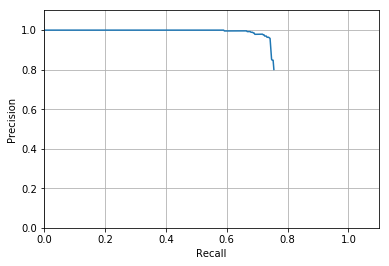

In [31]:
eval_utils.plot_pr_curve(zip(out[0], out[1]))

In [32]:
eval_utils.calc_auc(zip(out[0], out[1]), gt_mean_test)

0.75119634222623322